# 1-canyon run

## General description

$N_{shelf}\approx $ 1.47, 1.39, 1.39  1/s, mean= 1.41 1/s

In [1]:
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.polynomial import polynomial as P
import os
import pandas as pd
#import seaborn as sns
import scipy.io as sio
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('/ocean/kramosmu/MultipleCanyons/lab/Conduino/scripts')
import profiler_tools as ptools
import conduino_tools as ctools


In [2]:
sns.set_style('whitegrid')
sns.set_context('notebook')

In [4]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
def plot_uprofile(ax, col='0.8'):
    ax.axvline(21.0+15, color=col, linestyle=':')
    ax.axvline(71.0+15, color=col, linestyle=':')
        
def plot_forcing(ax, file, f0, f1, f2, t0, t1):
    '''ax: axes to plot figure on
       file: experiment file to extract time
       f0: Angular velocity of the table during spin up
       f1: f at max forcing
       f2: f to avoid spin down
       t0: time to get to f1
       t1: time to get to f2'''
    mat = sio.loadmat(file, squeeze_me=True)
    time = mat['time']
    t2 = np.round(np.max(time),2) # s

    ax0.text(0.3,0.3,r'$\Delta f_1=$%1.2f rad/s, $\Delta t_1=$%1.1f s' %((f1-f0),t0), transform=ax0.transAxes)
    ax0.text(0.5,0.7,r'$\Delta f_2=$%1.2f rad/s, $\Delta t_2=$%1.1f s' %((f2-f1),(t1-t0)), transform=ax0.transAxes)

    ax0.plot([0,t0,t1,t2],[f0,f1,f2,f2], 'g-')
    ax0.set_ylabel('f table / rad s$^{-1}$')
    ax0.set_xlabel('time / s')
    
def filter_timeseries(record, winlen=39):
    
    '''as in filter_timesies in salish sea tidetools.py without doodson option'''
    
    filtered = record.copy()
    record_length = record.shape[0]
    w = (winlen - 1) // 2
    weight = np.zeros(w, dtype=int)
    weight[:] = 1
    centerval = 1
    
    #Loop through record
    for i in range(record_length):
        
        # Adjust window length for end cases
        W = min(i, w, record_length-i-1)
        Weight = weight[:W]
        Weight = np.append(Weight[::-1], np.append(centerval, Weight))
        if sum(Weight) != 0:
            Weight = (Weight/sum(Weight))
        
        # Expand weight dims so it can operate on record window
        for dim in range(record.ndim - 1):
            Weight = Weight[:, np.newaxis]
        
        # Apply mean over window length
        if W > 0:
            filtered[i, ...] = np.sum(record[i-W:i+W+1, ...] * Weight, axis=0)
        else:
            filtered[i, ...] = record[i, ...]
    
    return filtered


Probes ANK1 upstream and ANK2 downstream. Both near head

|Channel|Probe|
|::|::|
|'ch1':|ANK1|
|'ch2':|ANK2|
|'ch3':|P21|



### All readings 

Text(0.5,0,'time / s')

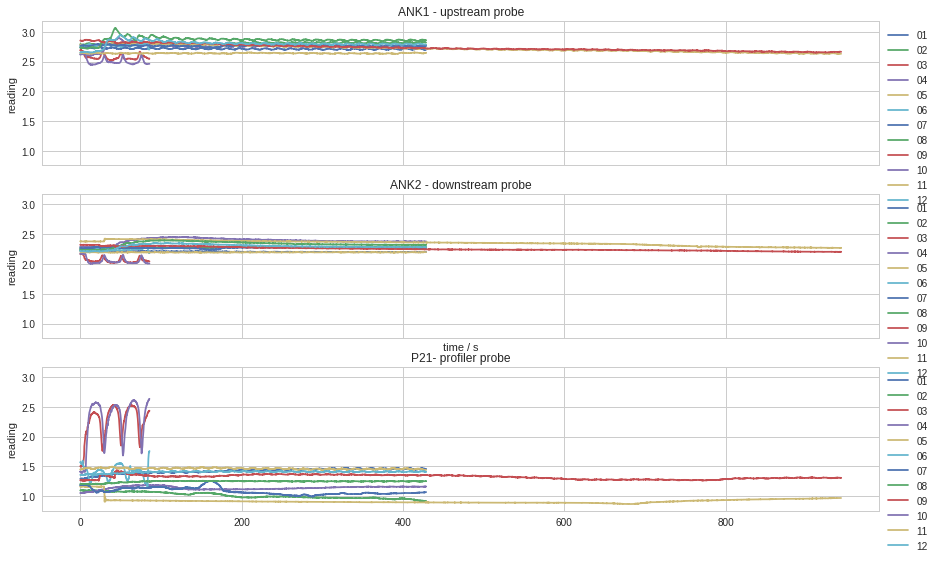

In [4]:
fig, (ax0,ax1, ax2) = plt.subplots(3,1, figsize=(15,9), sharex=True, sharey=True)

labels = [ '01','02','03','04','05','06','07','08','09','10','11','12']

filepaths = ['../experiments/exp_20aug19/01_base.mat',
             '../experiments/exp_20aug19/02_base.mat',
             '../experiments/exp_20aug19/03_profile1.mat',
             '../experiments/exp_20aug19/04_experiment1.mat',
             '../experiments/exp_20aug19/05_recovery1.mat',
             '../experiments/exp_20aug19/06_profile2.mat',
             '../experiments/exp_20aug19/07_base.mat',
             '../experiments/exp_20aug19/08_experiment2.mat',
             '../experiments/exp_20aug19/09_recovery2.mat',
             '../experiments/exp_20aug19/10_profile3.mat',
             '../experiments/exp_20aug19/11_base.mat',
             '../experiments/exp_20aug19/12_experiment3.mat',
             ]

for filepath, lab in zip(filepaths, labels):
    mat = sio.loadmat(filepath, squeeze_me=True)
    P1 = mat['ch1']
    P2 = mat['ch2']
    P3 = mat['ch3']
    time = mat['time']
    ax0.plot(time,P1, label=lab)
    ax1.plot(time,P2, label=lab)
    ax2.plot(time,P3, label=lab)

ax0.legend(bbox_to_anchor=(1,1))
ax1.legend(bbox_to_anchor=(1,1))
ax2.legend(bbox_to_anchor=(1,1))

ax1.set_ylabel('reading')#'density / g cm$^{-3}$')
ax0.set_ylabel('reading')#'density / g cm$^{-3}$')
ax2.set_ylabel('reading')#'density / g cm$^{-3}$')
ax0.set_title('ANK1 - upstream probe')
ax1.set_title('ANK2 - downstream probe')
ax2.set_title('P21- profiler probe')

ax1.set_xlabel('time / s')

### Base readings

Text(0.5,0,'time / s')

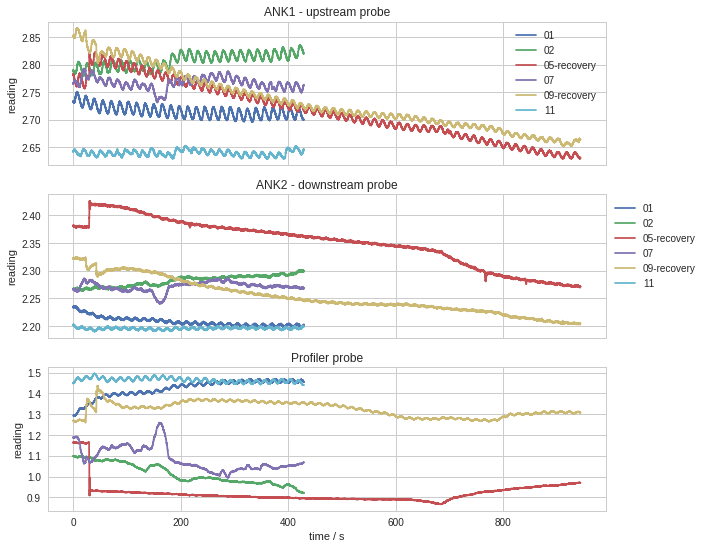

In [5]:
fig, (ax0,ax1, ax2) = plt.subplots(3,1, figsize=(10,9), sharex=True)

labels = ['01','02','05-recovery','07','09-recovery','11']

filepaths = ['../experiments/exp_20aug19/01_base.mat',
             '../experiments/exp_20aug19/02_base.mat',
             '../experiments/exp_20aug19/05_recovery1.mat',
             '../experiments/exp_20aug19/07_base.mat',
             '../experiments/exp_20aug19/09_recovery2.mat',
             '../experiments/exp_20aug19/11_base.mat'
             ]
sns.set_palette('plasma',n_colors=len(filepaths))
for filepath, lab in zip(filepaths, labels):
    mat = sio.loadmat(filepath, squeeze_me=True)
    P1 = mat['ch1']
    P2 = mat['ch2']
    P3 = mat['ch3']
    time = mat['time']
    ax0.plot(time,P1, label=lab)
    ax1.plot(time,P2, label=lab)
    ax2.plot(time,P3, label=lab)
 
ax0.legend(bbox_to_anchor=(1,1))
ax1.legend(bbox_to_anchor=(1,1))

ax1.set_ylabel('reading')#'density / g cm$^{-3}$')
ax0.set_ylabel('reading')#'density / g cm$^{-3}$')
ax2.set_ylabel('reading')#'density / g cm$^{-3}$')
ax0.set_title('ANK1 - upstream probe')
ax1.set_title('ANK2 - downstream probe')
ax2.set_title('Profiler probe')
ax2.set_xlabel('time / s')

### Profiles

../experiments/exp_20aug19/03_profile1.mat
../experiments/exp_20aug19/06_profile2.mat
../experiments/exp_20aug19/10_profile3.mat


Text(0.5,1,'Probe P21')

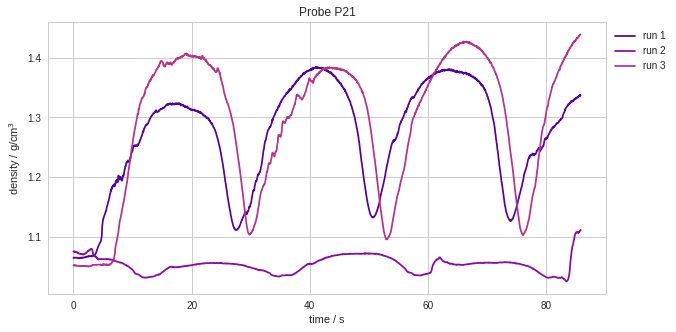

In [6]:
fig, ax0 = plt.subplots(1,1, figsize=(10,5), sharey=True)
labels = ['run 1', 'run 2', 'run 3']
files = ['../experiments/exp_20aug19/03_profile1.mat',
         '../experiments/exp_20aug19/06_profile2.mat',
         '../experiments/exp_20aug19/10_profile3.mat',
        ]

for filepath, lab in zip(files, labels):
    print(filepath)
    mat = sio.loadmat(filepath, squeeze_me=True)
    P3 = ctools.densP_17Aug19(mat['ch3'])
    time = mat['time']
    ax0.plot(time,P3,'-', label=lab)

ax0.legend(bbox_to_anchor=(1,1))
ax0.set_ylabel('density / g/cm$^3$')
ax0.set_xlabel('time / s')
ax0.set_title('Probe P21')


### Experiment

../experiments/exp_20aug19/04_experiment1.mat
../experiments/exp_20aug19/08_experiment2.mat
../experiments/exp_20aug19/12_experiment3.mat


Text(0.5,0,'sample')

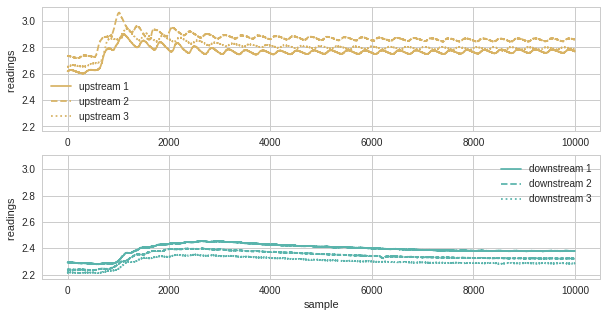

In [7]:
fig, (ax0,ax1) = plt.subplots(2,1, figsize=(10,5), sharey=True)
labels = [['upstream 1','downstream 1'],['upstream 2', 'downstream 2'],
          ['upstream 3', 'downstream 3'],['upstream 4', 'downstream 4']]
colors = ['#d8b365','#5ab4ac']
linestyles = ['-', '--',':','-.']
files = ['../experiments/exp_20aug19/04_experiment1.mat',
         '../experiments/exp_20aug19/08_experiment2.mat',
         '../experiments/exp_20aug19/12_experiment3.mat',
        ]
for filepath, lab, sty in zip(files, labels, linestyles):
    print(filepath)
    mat = sio.loadmat(filepath, squeeze_me=True)
    P1 = mat['ch1']
    P2 = mat['ch2']
    time = mat['time']
    ax0.plot(P1,'-', label=lab[0], color=colors[0], linestyle=sty)
    ax1.plot(P2,'-', label=lab[1], color=colors[1], linestyle=sty)
ax0.legend(loc=0)
ax1.legend(loc=0)
ax0.set_ylabel('readings ')
ax1.set_ylabel('readings ')
ax1.set_xlabel('sample')

../experiments/exp_20aug19/04_experiment1.mat
../experiments/exp_20aug19/08_experiment2.mat
../experiments/exp_20aug19/12_experiment3.mat


Text(0.5,1,'Probe density')

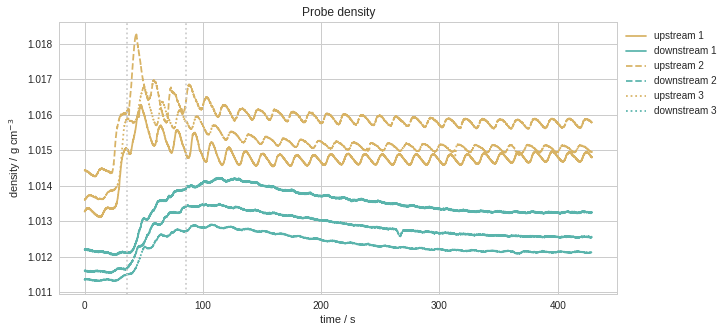

In [8]:
fig, ax0 = plt.subplots(1,1, figsize=(10,5), sharey=True)
labels = [['upstream 1','downstream 1'],['upstream 2', 'downstream 2'],
          ['upstream 3', 'downstream 3']]
colors = ['#d8b365','#5ab4ac']
linestyles = ['-', '--',':','-.']
files = ['../experiments/exp_20aug19/04_experiment1.mat',
         '../experiments/exp_20aug19/08_experiment2.mat',
         '../experiments/exp_20aug19/12_experiment3.mat',
        ]

for filepath, lab, sty in zip(files, labels, linestyles):
    print(filepath)
    mat = sio.loadmat(filepath, squeeze_me=True)
    P1 = mat['ch1']
    P2 = mat['ch2']
    time = mat['time']
    ax0.plot(time,ctools.densANK1_17Aug19(P1),'-', label=lab[0], color=colors[0], linestyle=sty)
    ax0.plot(time,ctools.densANK2_17Aug19(P2),'-', label=lab[1], color=colors[1], linestyle=sty)

plot_uprofile(ax0)
ax0.legend(bbox_to_anchor=(1,1))
ax0.set_ylabel('density / g cm$^{-3}$')
ax0.set_xlabel('time / s')
ax0.set_title('Probe density')


../experiments/exp_20aug19/04_experiment1.mat
../experiments/exp_20aug19/08_experiment2.mat
../experiments/exp_20aug19/12_experiment3.mat


Text(0.5,1,'Probe density minus initial density')

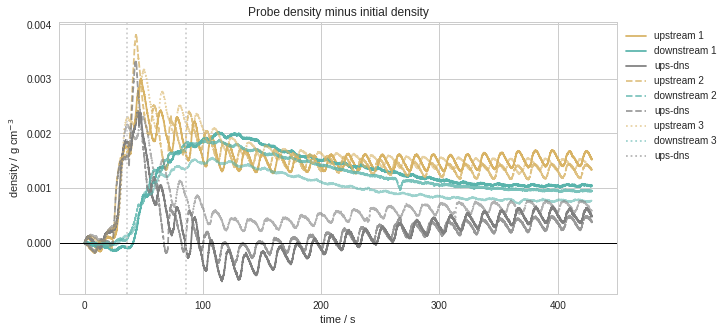

In [9]:
fig, (ax0) = plt.subplots(1,1, figsize=(10,5), sharey=True)

labels = [['upstream 1','downstream 1'],['upstream 2', 'downstream 2'],
          ['upstream 3', 'downstream 3'],['upstream 4', 'downstream 4']]
colors = ['#d8b365','#5ab4ac']
linestyles = ['-', '--',':','-.']
alphas = [1,0.8,0.6,0.3]
files = ['../experiments/exp_20aug19/04_experiment1.mat',
         '../experiments/exp_20aug19/08_experiment2.mat',
         '../experiments/exp_20aug19/12_experiment3.mat',
         ]

for filepath, lab, sty, alpha in zip(files, labels, linestyles, alphas):
    print(filepath)
    mat = sio.loadmat(filepath, squeeze_me=True)
    P1 = mat['ch1']
    P2 = mat['ch2']
    time = mat['time']
    ax0.plot(time,ctools.densANK1_17Aug19(P1)-ctools.densANK1_17Aug19(P1)[0],'-', 
             label=lab[0], color=colors[0], linestyle=sty, alpha=alpha)
    ax0.plot(time,ctools.densANK2_17Aug19(P2)-ctools.densANK2_17Aug19(P2)[0],'-', 
             label=lab[1], color=colors[1], linestyle=sty, alpha=alpha)
    ax0.plot(time,((ctools.densANK1_17Aug19(P1)-ctools.densANK1_17Aug19(P1)[0])-
                   (ctools.densANK2_17Aug19(P2)-ctools.densANK2_17Aug19(P2)[0])),
             '-', label='ups-dns',linestyle=sty, color='0.5', alpha=alpha)

plot_uprofile(ax0)
ax0.axhline(0,color='k', linewidth=1)
ax0.legend(bbox_to_anchor=(1,1))
ax0.set_ylabel('density / g cm$^{-3}$')
ax0.set_xlabel('time / s')
ax0.set_title('Probe density minus initial density')


../experiments/exp_20aug19/04_experiment1.mat
../experiments/exp_20aug19/08_experiment2.mat
../experiments/exp_20aug19/12_experiment3.mat


Text(0.5,1,'Probe density minus initial density')

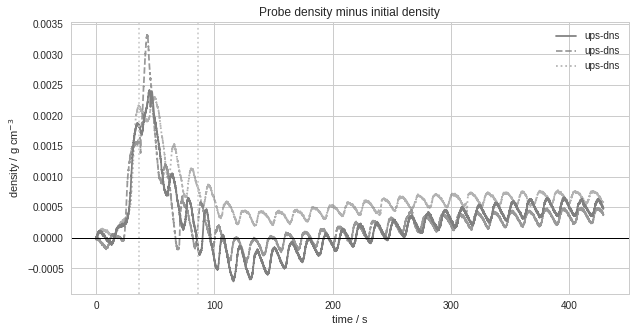

In [10]:
fig, (ax0) = plt.subplots(1,1, figsize=(10,5), sharey=True)

labels = [['upstream 1','downstream 1'],['upstream 2', 'downstream 2'],
          ['upstream 3', 'downstream 3'],['upstream 4', 'downstream 4']]
colors = ['#d8b365','#5ab4ac']
linestyles = ['-', '--',':','-.']
alphas = [1,0.8,0.6,0.3]
files = ['../experiments/exp_20aug19/04_experiment1.mat',
         '../experiments/exp_20aug19/08_experiment2.mat',
         '../experiments/exp_20aug19/12_experiment3.mat',
         ]

for filepath, lab, sty, alpha in zip(files, labels, linestyles, alphas):
    print(filepath)
    mat = sio.loadmat(filepath, squeeze_me=True)
    P1 = mat['ch1']
    P2 = mat['ch2']
    time = mat['time']
    #ax0.plot(time,ctools.densANK1_17Aug19(P1)-ctools.densANK1_17Aug19(P1)[0],'-', 
    #         label=lab[0], color=colors[0], linestyle=sty, alpha=alpha)
    #ax0.plot(time,ctools.densANK2_17Aug19(P2)-ctools.densANK2_17Aug19(P2)[0],'-', 
    #         label=lab[1], color=colors[1], linestyle=sty, alpha=alpha)
    ax0.plot(time,((ctools.densANK1_17Aug19(P1)-ctools.densANK1_17Aug19(P1)[0])-
                   (ctools.densANK2_17Aug19(P2)-ctools.densANK2_17Aug19(P2)[0])),
             '-', label='ups-dns',linestyle=sty, color='0.5', alpha=alpha)

plot_uprofile(ax0)
ax0.axhline(0,color='k', linewidth=1)
ax0.legend(bbox_to_anchor=(1,1))
ax0.set_ylabel('density / g cm$^{-3}$')
ax0.set_xlabel('time / s')
ax0.set_title('Probe density minus initial density')


../experiments/exp_20aug19/04_experiment1.mat
../experiments/exp_20aug19/08_experiment2.mat
../experiments/exp_20aug19/12_experiment3.mat


Text(0.5,1,'Downstream probe (shelf)')

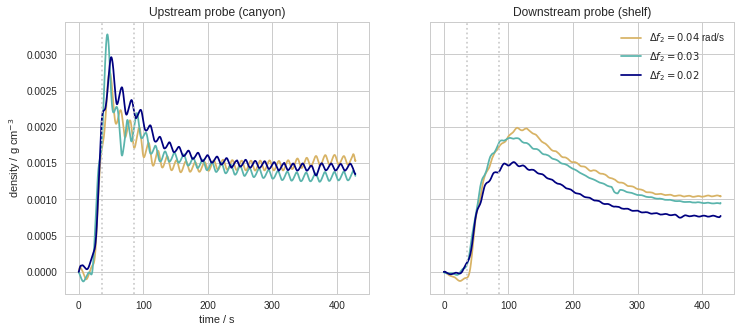

In [16]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,5), sharey=True)
labels = [r'$\Delta f_2=0.04$ rad/s',r'$\Delta f_2=0.03$',r'$\Delta f_2=0.02$']
colors = ['#d8b365','#5ab4ac','navy']
linestyles = ['-', '--',':','-.']
files = ['../experiments/exp_20aug19/04_experiment1.mat',
         '../experiments/exp_20aug19/08_experiment2.mat',
         '../experiments/exp_20aug19/12_experiment3.mat',
        ]

for filepath, lab, color in zip(files, labels, colors):
    print(filepath)
    mat = sio.loadmat(filepath, squeeze_me=True)
    P1 = mat['ch1']
    P2 = mat['ch2']
    dt = mat['dt']
    time = mat['time']
    inertial_period = 1/((0.7)/(2*np.pi))
    win = int(inertial_period/dt)
    dens1 = filter_timeseries(ctools.densANK1_17Aug19(P1),winlen=win)
    dens2 = filter_timeseries(ctools.densANK2_17Aug19(P2),winlen=win)
    ax0.plot(time,dens1-dens1[0],'-', label=lab, color=color)
    ax1.plot(time,dens2-dens2[0],'-', label=lab, color=color)

plot_uprofile(ax0)
plot_uprofile(ax1)
ax1.legend(bbox_to_anchor=(1,1))

ax0.set_ylabel('density / g cm$^{-3}$')
ax0.set_xlabel('time / s')
ax0.set_title('Upstream probe (canyon)')
ax1.set_title('Downstream probe (shelf)')

Filtered timeseries using window = inertial period. There is no bump in downstream canyon compared to what happened yesterday with larger stratification and f=0.7. A lot less waves, they are amplified inside the canyon.

In [12]:
g=9.81
rho_0=998.6

# N above sb run1
N1 = np.sqrt((g/rho_0)*((1016.86-1010.37))/0.0295)
print(N1)


1.47011078358143


In [13]:
# N above sb run2
N2 = np.sqrt((g/rho_0)*(1016.62-1010.86)/0.0295)
print(N2)


1.3849655046336866


In [14]:
# N above sb run2
N3 = np.sqrt((g/rho_0)*(1016.66-1010.98)/0.029) 
print(N3)


1.3871195469187683


In [15]:
np.mean(np.array([N1,N2,N3]))

1.4140652783779615